In [19]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
)
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Base paths – adjust if needed
BASE_DIR   = Path("D:/Sheridan/First semester/Python/LyriSense")
DATA_CLEAN = BASE_DIR / "data" / "cleaned"
MODELS_DIR = BASE_DIR / "models"


In [20]:
emotion_df = pd.read_csv(DATA_CLEAN / "emotion_clean.csv")
songs_df   = pd.read_csv(DATA_CLEAN / "songs_clean.csv")

print("Emotion data shape:", emotion_df.shape)
print("Songs data shape:", songs_df.shape)

emotion_df.head(), songs_df.head()


Emotion data shape: (416796, 2)
Songs data shape: (611, 6)


(                                                text  emotion_id
 0      i just feel really helpless and heavy hearted           4
 1  ive enjoyed being able to slouch about relax a...           0
 2  i gave up my internship with the dmrg and am f...           4
 3                         i dont know i feel so lost           0
 4  i am a kindergarten teacher and i am thoroughl...           4,
                                  title             artist  \
 0               A Whiter Shade Of Pale       Procol Harum   
 1                        My Sweet Lord    George Harrison   
 2                God Only Knows - Mono     The Beach Boys   
 3           Bridge Over Troubled Water  Simon & Garfunkel   
 4  Bohemian Rhapsody - Remastered 2011              Queen   
 
                                      album  popularity  \
 0                   A Whiter Shade Of Pale           0   
 1        All Things Must Pass (Remastered)           0   
 2  Pet Sounds (Original Mono & Stereo Mix)         

In [21]:
tfidf_emotion = joblib.load(MODELS_DIR / "tfidf_emotion.joblib")
logreg_emotion = joblib.load(MODELS_DIR / "logreg_emotion.joblib")

print(tfidf_emotion)
print(logreg_emotion)


TfidfVectorizer(max_features=20000, min_df=5, ngram_range=(1, 2))
LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1)


In [22]:
# Use the already-fitted TF-IDF vectorizer
X_songs = tfidf_emotion.transform(songs_df["clean_lyrics"])

X_songs.shape


(611, 20000)

In [23]:
# Class probabilities for each song
song_proba = logreg_emotion.predict_proba(X_songs)

# Top emotion id
song_pred_ids = song_proba.argmax(axis=1)

# Confidence = max probability
song_conf = song_proba.max(axis=1)

songs_df["pred_emotion_id"] = song_pred_ids
songs_df["pred_emotion_conf"] = song_conf

# Map ids -> readable labels (adjust names if your mapping is different)
id2label = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise",
}

songs_df["pred_emotion"] = songs_df["pred_emotion_id"].map(id2label)

songs_df[["title", "artist", "pred_emotion_id", "pred_emotion", "pred_emotion_conf"]].head()


,title,artist,pred_emotion_id,pred_emotion,pred_emotion_conf
0,A Whiter Shade Of Pale,Procol Harum,5,surprise,0.354224
1,My Sweet Lord,George Harrison,2,love,0.884122
2,God Only Knows - Mono,The Beach Boys,0,sadness,0.223963
3,Bridge Over Troubled Water,Simon & Garfunkel,0,sadness,0.877587
4,Bohemian Rhapsody - Remastered 2011,Queen,2,love,0.939979


pred_emotion_id
0    135
1    108
2    231
3     73
4     17
5     47
Name: count, dtype: int64


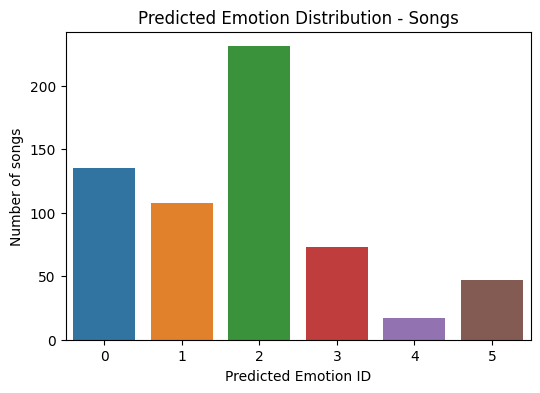

In [24]:
songs_counts = songs_df["pred_emotion_id"].value_counts().sort_index()
print(songs_counts)

plt.figure(figsize=(6,4))
sns.barplot(x=songs_counts.index, y=songs_counts.values)
plt.xlabel("Predicted Emotion ID")
plt.ylabel("Number of songs")
plt.title("Predicted Emotion Distribution - Songs")
plt.show()


In [25]:
out_path = DATA_CLEAN / "songs_with_predicted_emotions.csv"
songs_df.to_csv(out_path, index=False)
out_path


WindowsPath('D:/Sheridan/First semester/Python/LyriSense/data/cleaned/songs_with_predicted_emotions.csv')

In [26]:
def recommend_songs(user_text, top_k=5, min_conf=0.3):
    """
    Given a user_text, predict its emotion and return top_k song recommendations.
    """
    # 1) Vectorize user text
    X_user = tfidf_emotion.transform([user_text])
    
    # 2) Predict emotion distribution
    user_proba = logreg_emotion.predict_proba(X_user)[0]
    user_emotion_id = int(user_proba.argmax())
    user_emotion_label = id2label[user_emotion_id]
    user_conf = float(user_proba.max())
    
    # 3) Filter candidate songs by same emotion + minimum song confidence
    same_emotion = songs_df["pred_emotion_id"] == user_emotion_id
    confident    = songs_df["pred_emotion_conf"] >= min_conf
    candidate_mask = same_emotion & confident
    
    candidate_indices = np.where(candidate_mask)[0]
    
    # Fallback: if filter is too strict, ignore min_conf
    if len(candidate_indices) == 0:
        candidate_indices = np.where(same_emotion)[0]
    # Fallback 2: if literally nothing matches, use all songs
    if len(candidate_indices) == 0:
        candidate_indices = np.arange(len(songs_df))
    
    X_candidates = X_songs[candidate_indices]
    
    # 4) Cosine similarity between user text and candidate songs
    sims = cosine_similarity(X_user, X_candidates)[0]
    top_idx = sims.argsort()[::-1][:top_k]
    
    top_song_indices = candidate_indices[top_idx]
    
    results = songs_df.iloc[top_song_indices].copy()
    results["similarity"] = sims[top_idx]
    
    return {
        "user_emotion_id": user_emotion_id,
        "user_emotion_label": user_emotion_label,
        "user_emotion_conf": user_conf,
        "recommendations": results[[
            "title", "artist", "album",
            "pred_emotion", "pred_emotion_conf", "similarity"
        ]]
    }


In [27]:
example_text = "i feel really anxious and overwhelmed about tomorrow"
res = recommend_songs(example_text, top_k=5)

print(f"User text predicted emotion: {res['user_emotion_label']} "
      f"(id={res['user_emotion_id']}, conf={res['user_emotion_conf']:.3f})")

res["recommendations"]


User text predicted emotion: fear (id=4, conf=0.912)


,title,artist,album,pred_emotion,pred_emotion_conf,similarity
449,10:35,Tiësto,10:35,fear,0.384485,0.034979
274,Renegade,JAY-Z,Curtain Call: The Hits (Deluxe Edition),fear,0.512791,0.018514
226,Not Afraid,Eminem,Recovery,fear,0.346295,0.008049
497,505,Arctic Monkeys,Favourite Worst Nightmare,fear,0.510901,0.007118
330,Middle Ground,Maroon 5,Middle Ground,fear,0.444407,0.006847
